# Introdução à Aprendizagem de Máquina - Trabalho Final

## 1. A base de dados "A Large Scale Fish Dataset"

In [9]:
import kaggle
import pathlib

In [12]:
wd = pathlib.Path().absolute().as_posix()

kaggle.api.authenticate()
kaggle.api.dataset_download_files('crowww/a-large-scale-fish-dataset', path=wd+'/dataset', unzip=True)

## 2. Implementação original do baseline, utilizando DenseNet implementado em Keras

In [14]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [27]:
image_dir = Path('dataset/Fish_Dataset/Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]
image_df

,Filepath,Label
0,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
1,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
2,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
3,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
4,dataset/Fish_Dataset/Fish_Dataset/Black Sea Sp...,Black Sea Sprat
...,...,...
16995,dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/...,Trout
16996,dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/...,Trout
16997,dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/...,Trout
16998,dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/...,Trout


In [28]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,dataset/Fish_Dataset/Fish_Dataset/Trout/Trout/...,Trout
1,dataset/Fish_Dataset/Fish_Dataset/Hourse Macke...,Hourse Mackerel
2,dataset/Fish_Dataset/Fish_Dataset/Sea Bass/Sea...,Sea Bass


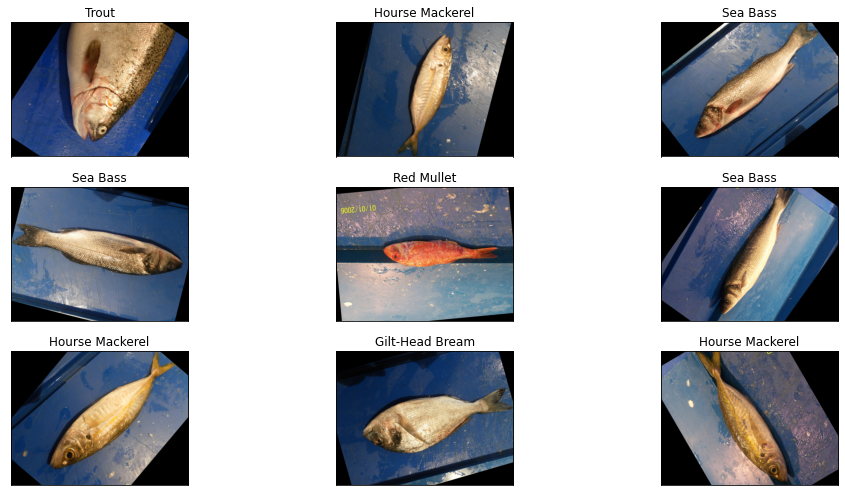

In [29]:
# Display 9 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [30]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [31]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [32]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [33]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9412608/9406464 [==============================] - 1s 0us/step


In [35]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
203/203 [==============================] - 370s 2s/step - loss: 0.5078 - accuracy: 0.8465 - val_loss: 0.0413 - val_accuracy: 0.9864
Epoch 2/50
203/203 [==============================] - 346s 2s/step - loss: 0.0173 - accuracy: 0.9947 - val_loss: 0.0517 - val_accuracy: 0.9833
Epoch 3/50
203/203 [==============================] - 344s 2s/step - loss: 0.0151 - accuracy: 0.9947 - val_loss: 0.0048 - val_accuracy: 0.9988
Epoch 4/50
203/203 [==============================] - 334s 2s/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.0077 - val_accuracy: 0.9981
Epoch 5/50
203/203 [==============================] - 325s 2s/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0054 - val_accuracy: 0.9981


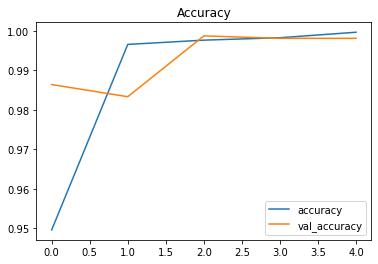

In [36]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

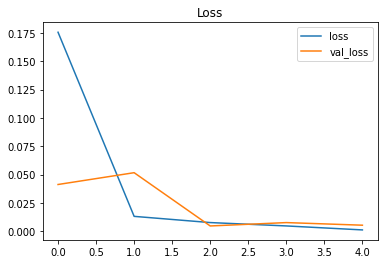

In [37]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [38]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00860
Test Accuracy: 99.89%


In [39]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Trout', 'Shrimp', 'Trout', 'Striped Red Mullet', 'Black Sea Sprat']


In [40]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       104
   Gilt-Head Bream       1.00      1.00      1.00        94
   Hourse Mackerel       1.00      1.00      1.00       104
        Red Mullet       1.00      0.99      1.00       107
     Red Sea Bream       1.00      1.00      1.00       101
          Sea Bass       1.00      1.00      1.00        93
            Shrimp       1.00      1.00      1.00        96
Striped Red Mullet       0.99      1.00      0.99        92
             Trout       1.00      1.00      1.00       109

          accuracy                           1.00       900
         macro avg       1.00      1.00      1.00       900
      weighted avg       1.00      1.00      1.00       900



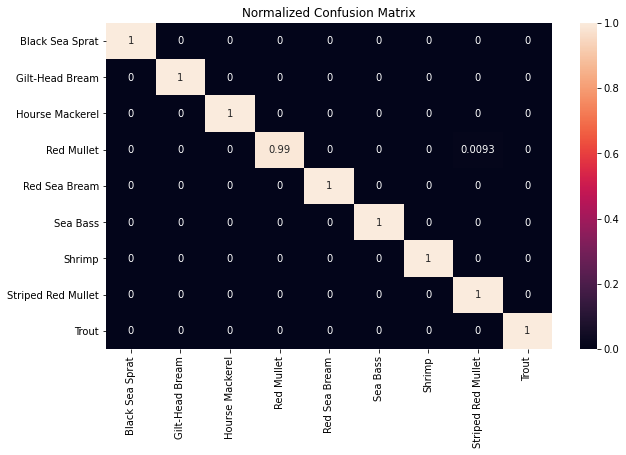

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

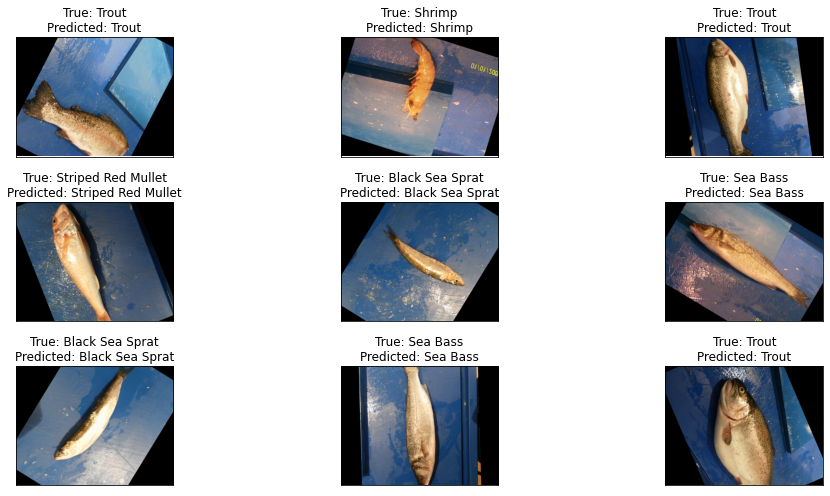

In [44]:
# Display 9 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

## 3. Implementação do baseline, utilizando DenseNet implementado em PyTorch

## 4. Classificação com o uso de SVM

## 5. Aplicando a implementação original ao dataset X

## 6. Aplicando a implementação em PyTorch ao dataset X

## 7. Aplicando a implementação com SVM ao dataset X

## 7. Comparando os resultados

## 8. Referências

- O.Ulucan , D.Karakaya and M.Turkan.(2020) A large-scale dataset for fish segmentation and classification. In Conf. Innovations Intell. Syst. Appli. (ASYU)
- Huang, G., Liu, Z., Weinberger, K. Q., & van der Maaten, L. (2016). Densely connected convolutional networks. arXiv preprint arXiv:1608.06993.
- Huang, G., Sun, Y., Liu, Z., Sedra, D., & Weinberger, K. Q. (2016). Deep networks with stochastic depth. In European Conference on Computer Vision (ECCV '16)